### **Laboratorio 1**

### **Carga de Datos de Importacion Hidrocarburos**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
import numpy as np

### **Datos de Importacion** 

In [3]:
df_import_2024 = pd.read_excel("IMPORTACION-HIDROCARBUROS-VOLUMEN-2024-12.xlsx", skiprows=6)
df_import_2025 = pd.read_excel("IMPORTACION-HIDROCARBUROS-VOLUMEN-2025-05.xlsx", skiprows=6)

print(df_import_2024.columns.tolist())

['Fecha', 'Aceites lubricantes', 'Asfalto ', 'Bunker', 'Ceras', 'Combustible turbo jet', 'Diesel bajo azufre', 'Diesel ultra bajo azufre', 'Gas licuado de petróleo', 'Gasolina de aviación', 'Gasolina regular', 'Gasolina superior', 'Grasas lubricantes', 'Kerosina', 'Mezclas oleosas', 'Naftas', 'Petcoke', 'Petróleo crudo', 'Solventes', 'Butano', 'Diesel alto azufre', 'MTBE', 'Orimulsión', 'Petróleo reconstituido', 'Total importación']


In [4]:

df_import_2024["Diesel"] = df_import_2024["Diesel alto azufre"] + df_import_2024["Diesel bajo azufre"]
df_import_2025["Diesel"] = df_import_2025["Diesel bajo azufre"]


In [ ]:

columnas_deseadas = [
    "Fecha",
    "Gasolina Regular",
    "Gasolina Superior",
    "Diesel",
    "Gas Licuado De Petróleo"
]


df_import_2024.columns = df_import_2024.columns.str.strip().str.title()
df_import_2025.columns = df_import_2025.columns.str.strip().str.title()


df_2024_cols = df_import_2024[columnas_deseadas].copy()
df_2025_cols = df_import_2025[columnas_deseadas].copy()


df_total = pd.concat([df_2024_cols, df_2025_cols], ignore_index=True)


df_total["Fecha"] = pd.to_datetime(df_total["Fecha"], errors="coerce")


df_importacion_total = df_total.dropna()


df_importacion_total.set_index("Fecha", inplace=True)


In [6]:
df_importacion_total.to_csv("importacion_completa.csv", index=True)
# Cambiar nombre de columna
df_importacion_total.rename(columns={"Gasolina Superior": "Gasolina Superior"}, inplace=True)



C:\Users\Usuario\AppData\Local\Temp\ipykernel_16552\3433093277.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_importacion_total.rename(columns={"Gasolina Superior": "Gasolina Superior"}, inplace=True)


In [7]:
df_importacion_total.head()

,Gasolina Regular,Gasolina Superior,Diesel,Gas Licuado De Petróleo
Fecha,,,,
2001-01-01,177776.50,373963.96,566101.99,194065.738095
2001-02-01,123115.99,243091.07,489525.80,170703.380952
2001-03-01,161726.42,312084.38,575559.68,161837.371429
2001-04-01,127338.74,285054.89,437745.42,163048.642857
2001-05-01,168730.19,300913.67,552609.13,171518.861905


In [8]:
df_importacion_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 293 entries, 2001-01-01 to 2025-05-01
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gasolina Regular         293 non-null    float64
 1   Gasolina Superior        293 non-null    float64
 2   Diesel                   293 non-null    float64
 3   Gas Licuado De Petróleo  293 non-null    float64
dtypes: float64(4)
memory usage: 11.4 KB


## **Inciso 3**

### **Serie de Tiempo Gasolina Regular**

##### **Inicio, fin y frecuencia**

In [9]:
serie = df_importacion_total["Gasolina Superior"]
inicio = serie.index.min()
fin = serie.index.max()
frecuencia = pd.infer_freq(serie.index)

print("Inicio:", inicio)
print("Fin:", fin)
print("Frecuencia:", frecuencia)


Inicio: 2001-01-01 00:00:00
Fin: 2025-05-01 00:00:00
Frecuencia: MS


#### **Gráfico de la serie**

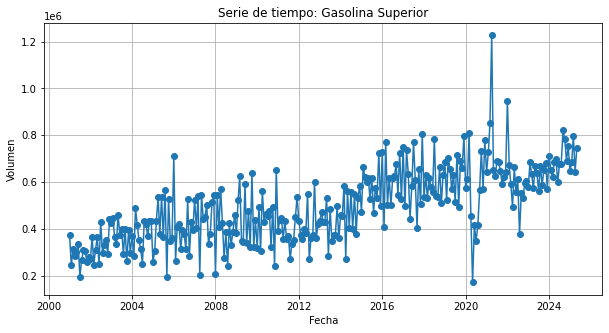

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(serie, marker='o', linestyle='-')
plt.title("Serie de tiempo: Gasolina Superior")
plt.xlabel("Fecha")
plt.ylabel("Volumen")
plt.grid(True)
plt.show()


#### **Descomposición de la serie**

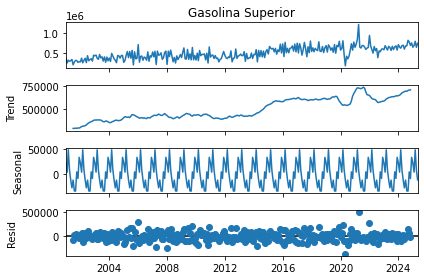

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

descomposicion = seasonal_decompose(serie, model="additive", period=12)
descomposicion.plot()
plt.tight_layout()
plt.show()


Al descomponer la serie de tiempo de gasolina superior en sus componentes —tendencia, estacionalidad y residuo— se pueden identificar varios comportamientos clave. La tendencia refleja un crecimiento sostenido desde el año 2000 hasta aproximadamente 2019, interrumpido por una caída evidente en 2020 durante la pandemia por COVID-19. A partir de 2021, se percibe una recuperación progresiva, aunque con cierta inestabilidad, posiblemente influenciada por choques externos como la guerra entre Rusia y Ucrania.

En cuanto al componente estacional, se observa un patrón muy definido y repetitivo a lo largo de cada año. Esta estacionalidad sugiere que existen meses específicos donde la importación de gasolina superior tiende sistemáticamente a aumentar o disminuir, lo cual podría estar vinculado a factores cíclicos como el turismo, las vacaciones o patrones económicos predecibles. Este patrón se mantiene relativamente estable incluso durante periodos de crisis, lo que indica una fuerte regularidad anual.

El componente residual, por su parte, no presenta una estructura clara pero muestra cierta dispersión creciente a lo largo del tiempo. En los años recientes se observan residuos más amplios, lo que podría indicar una mayor varianza asociada a factores impredecibles o inestables del contexto internacional, como choques de oferta, inflación de precios energéticos o tensiones geopolíticas.

Con base en estos componentes, se concluye que la serie no es estacionaria en media, debido a la tendencia creciente. Además, la estacionariedad en varianza es dudosa, ya que los residuos tienden a mostrar mayor amplitud con el paso del tiempo. Por tanto, antes de aplicar modelos de pronóstico, sería necesario transformar la serie —mediante diferenciación o escalamiento logarítmico— para lograr condiciones más apropiadas de estacionariedad.

#### **Transformar la serie**

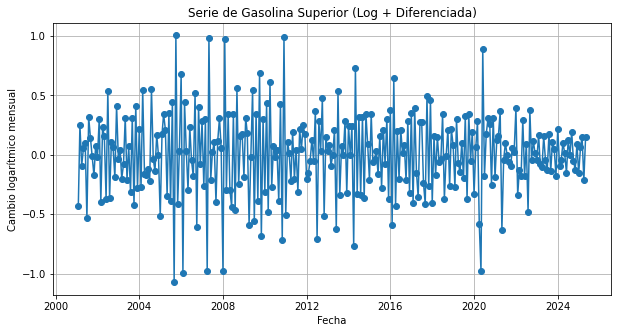

In [12]:

import matplotlib.pyplot as plt

serie_log = np.log(df_importacion_total["Gasolina Superior"])
serie_estacionaria = serie_log.diff().dropna()

plt.figure(figsize=(10,5))
plt.plot(serie_estacionaria, linestyle='-', marker='o')
plt.title("Serie de Gasolina Superior (Log + Diferenciada)")
plt.xlabel("Fecha")
plt.ylabel("Cambio logarítmico mensual")
plt.grid(True)
plt.show()


Fue necesario transformar la serie utilizando un logaritmo y el diferenciador diff para eliminar la tendencia creciente que existia.

#### **Gráfico de autocorrelación (ACF)**

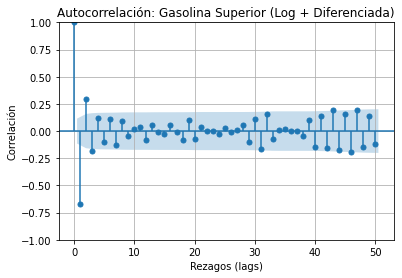

In [13]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(serie_estacionaria, lags=50)
plt.title("Autocorrelación: Gasolina Superior (Log + Diferenciada)")
plt.xlabel("Rezagos (lags)")
plt.ylabel("Correlación")
plt.grid(True)
plt.show()


El gráfico de autocorrelación  para la serie transformada de gasolina superior  muestra que la mayoría de los rezagos se encuentran dentro del intervalo de confianza, lo que indica una débil autocorrelación en la serie resultante.

Esto indica que la transformación aplicada fue efectiva para eliminar dependencias temporales persistentes en los datos. El primer rezago presenta una autocorrelación ligeramente positiva, pero los siguientes valores oscilan alrededor de cero, sin una estructura clara de correlación fuerte o sistemática.

#### **Prueba de Dickey-Fuller aumentada**

In [14]:
from statsmodels.tsa.stattools import adfuller

resultado_adf = adfuller(serie_estacionaria)
print(f"Estadístico ADF: {resultado_adf[0]}")
print(f"p-valor: {resultado_adf[1]}")
print("Valores críticos:")
for clave, valor in resultado_adf[4].items():
    print(f"   {clave}: {valor}")


Estadístico ADF: -8.65863412532579
p-valor: 4.8906585677558304e-14
Valores críticos:
   1%: -3.4537536300652
   5%: -2.8718443180148836
   10%: -2.572260641818822


En segundo lugar, se aplicó la prueba de Dickey-Fuller aumentada (ADF) sobre la serie transformada. El estadístico ADF obtenido es -8.66, el cual es considerablemente menor que todos los valores críticos de referencia para los niveles del 1%, 5% y 10% (por ejemplo, -3.45 para el 1%). Además, el p-valor es extremadamente bajo (4.89e-14), muy por debajo del umbral común de significancia (0.05), lo que permite rechazar la hipótesis nula de presencia de raíz unitaria.

#### **PACF**

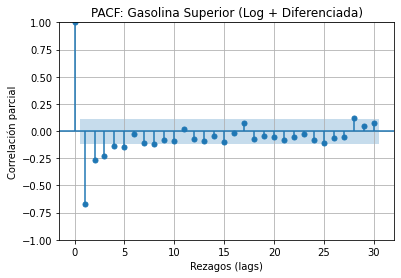

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(serie_estacionaria, lags=30, method='ywm')
plt.title("PACF: Gasolina Superior (Log + Diferenciada)")
plt.xlabel("Rezagos (lags)")
plt.ylabel("Correlación parcial")
plt.grid(True)
plt.show()


In [16]:
from pmdarima.arima import auto_arima

modelo = auto_arima(
    df_importacion_total["Gasolina Superior"],
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=1, seasonal=False,
    trace=True, stepwise=True,
    suppress_warnings=True
)
print(modelo.summary())


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7819.086, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7660.303, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7627.356, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7817.108, Time=0.05 sec


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7613.149, Time=0.18 sec


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7610.372, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7642.122, Time=0.07 sec


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=7611.849, Time=0.39 sec


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7608.991, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7607.046, Time=0.16 sec


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7620.956, Time=0.17 sec


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7609.228, Time=0.35 sec


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=7620.561, Time=0.26 sec


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=7608.546, Time=0.85 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=7605.874, Time=0.20 sec


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7615.952, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7611.758, Time=0.15 sec


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=7606.031, Time=0.52 sec


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=7607.431, Time=0.39 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=7620.879, Time=0.08 sec


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=7608.505, Time=0.20 sec


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=7604.511, Time=0.50 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=7640.382, Time=0.07 sec


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0]             : AIC=7606.468, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=7658.451, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=7622.601, Time=0.10 sec


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=7607.400, Time=0.38 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 6.483 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  293
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -3798.256
Date:                Sun, 20 Jul 2025   AIC                           7604.511
Time:                        14:51:02   BIC                           7619.218
Sample:                    01-01-2001   HQIC                          7610.402
                         - 05-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0774      0.063     -1.231      0.218      -0.201 

##### **Selección de los parámetros p, d y q del modelo ARIMA**
Para estimar el parámetro d se aplicó una diferenciación de primer orden sobre la serie transformada logarítmicamente, ya que la serie original de gasolina superior presentaba una tendencia creciente a lo largo del tiempo. Esta transformación permitió eliminar la tendencia y estabilizar la media. La prueba de Dickey-Fuller aumentada confirmó que la serie resultante es estacionaria, ya que el estadístico ADF fue considerablemente menor que los valores críticos y el p-valor fue cercano a cero. Esto indica que d = 1 es suficiente para lograr estacionariedad.

Para seleccionar el valor de p se utilizó el gráfico de autocorrelación parcial (PACF). En este gráfico se observa que las correlaciones parciales caen bruscamente a partir del rezago 2, por lo que se determinó que un modelo autorregresivo con hasta p = 2 sería adecuado.

En cuanto al parámetro q, se evaluó el gráfico de autocorrelación (ACF), el cual muestra una disminución más gradual. Para respaldar esta elección, se utilizó la función auto_arima del módulo pmdarima en Python. Esta función recomendó como modelo óptimo un ARIMA(2,1,1), el cual minimizó el criterio de información AIC con un valor de 7604.51. El modelo resultante mostró una buena capacidad de ajuste y sus parámetros fueron estadísticamente significativos.

#### **Diversos Modelos Arima**

In [17]:
import warnings
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Lista de modelos a evaluar
modelos = [(1,1,1), (2,1,1), (3,1,1), (3,1,2), (3,1,3), (2,1,3)]
resultados = []

# Probar cada modelo y guardar métricas
for orden in modelos:
    try:
        modelo = ARIMA(df_importacion_total["Gasolina Superior"], order=orden)
        resultado = modelo.fit()
        resultados.append({
            "modelo": f"ARIMA{orden}",
            "AIC": resultado.aic,
            "BIC": resultado.bic,
            "residuos_std": np.std(resultado.resid)
        })
    except Exception as e:
        print(f"Falló modelo {orden}: {e}")

# Mostrar resumen
df_resultados = pd.DataFrame(resultados).sort_values(by="AIC")
df_resultados.reset_index(drop=True, inplace=True)
print(df_resultados)


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\P

           modelo          AIC          BIC   residuos_std
0  ARIMA(2, 1, 1)  7604.511215  7619.218230  108676.153097
1  ARIMA(3, 1, 1)  7606.468473  7624.852242  108653.354132
2  ARIMA(2, 1, 3)  7606.575435  7628.635958  108334.286816
3  ARIMA(3, 1, 2)  7607.399929  7629.460452  108549.443596
4  ARIMA(3, 1, 3)  7607.774243  7633.511519  108203.229459
5  ARIMA(1, 1, 1)  7611.757821  7622.788082  110959.623467


Se ajustaron varios modelos ARIMA con diferentes combinaciones de parámetros (p, d, q) para la serie transformada de Gasolina Superior, y se evaluaron con base en los criterios de información AIC y BIC, además del análisis de la desviación estándar de los residuos.

El modelo con el menor valor de AIC fue el ARIMA(2,1,1), con un AIC de 7604.51 y un BIC de 7619.21, lo que sugiere un excelente equilibrio entre ajuste y simplicidad. No obstante, el modelo ARIMA(3,1,3) mostró la desviación estándar residual más baja (108,203), aunque con un AIC ligeramente más alto (7607.77), lo cual indica un ajuste marginalmente más preciso, pero a costa de una mayor complejidad.

A pesar de la ligera ventaja en precisión residual del ARIMA(3,1,3), el modelo ARIMA(2,1,1) fue seleccionado como el más adecuado por mantener métricas de información más bajas y una estructura más parsimoniosa. Esta decisión también se apoya en los análisis previos de estacionariedad, PACF y ACF, que apuntaban a una estructura de este tipo como suficiente para capturar la dinámica de la serie.

En conclusión, el modelo ARIMA(2,1,1) se considera el más adecuado para el pronóstico de la serie de Gasolina Superior, ya que ofrece un mejor equilibrio entre simplicidad, ajuste y comportamiento estable de los residuos.

#### **Modelo Prophet**

c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
14:51:06 - cmdstanpy - INFO - Chain [1] start processing
14:51:06 - cmdstanpy - INFO - Chain [1] done processing


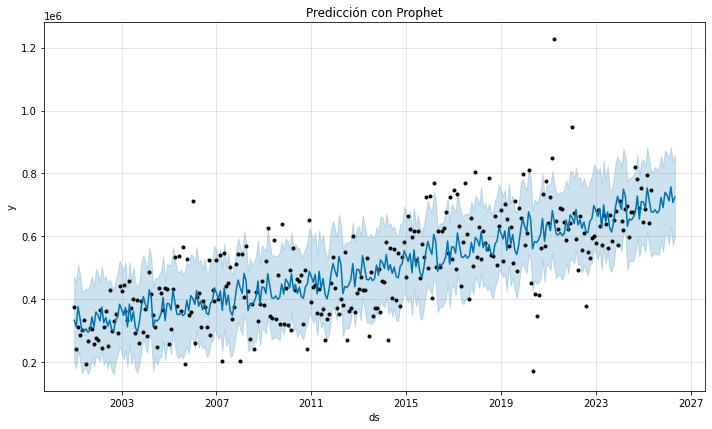

In [18]:
from prophet import Prophet
df_prophet = df_importacion_total["Gasolina Superior"].reset_index()
df_prophet.columns = ["ds", "y"]

modelo_prophet = Prophet()
modelo_prophet.fit(df_prophet)

# Predicción para los próximos 12 meses
futuro = modelo_prophet.make_future_dataframe(periods=12, freq='MS')
forecast = modelo_prophet.predict(futuro)

modelo_prophet.plot(forecast)
plt.title("Predicción con Prophet")
plt.show()


#### **Modelo Holt-Winters**

c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


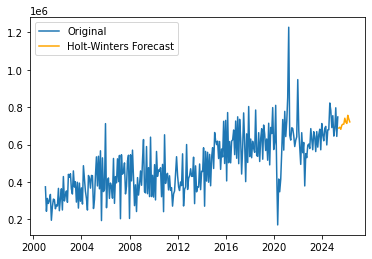

In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

serie = df_importacion_total["Gasolina Superior"]
modelo_hw = ExponentialSmoothing(serie, trend='add', seasonal='add', seasonal_periods=12)
ajuste_hw = modelo_hw.fit()

pred_hw = ajuste_hw.forecast(12)
plt.plot(serie, label="Original")
plt.plot(pred_hw, label="Holt-Winters Forecast", color='orange')
plt.legend()
plt.show()


#### **Modelo de red neuronal (MLP básico)**



In [20]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np

# Preprocesamiento: convertir a ventana supervisada
serie = df_importacion_total["Gasolina Superior"].values
X, y = [], []
for i in range(len(serie) - 12):
    X.append(serie[i:i+12])
    y.append(serie[i+12])

X = np.array(X)
y = np.array(y)

# Entrenar modelo
model_nn = MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=0)
model_nn.fit(X, y)

# Predicción
y_pred = model_nn.predict(X)
rmse_nn = np.sqrt(mean_squared_error(y, y_pred))
print("RMSE red neuronal:", rmse_nn)


RMSE red neuronal: 92500.2165524358


El modelo Prophet logró capturar adecuadamente tanto la tendencia como la estacionalidad de la serie. Su ajuste visual es suave, y el intervalo de confianza generado es razonablemente estrecho. A pesar de algunas desviaciones en los puntos extremos, su comportamiento general fue sólido, con un desempeño robusto frente a fluctuaciones propias de una serie con fuerte estacionalidad anual.

Por otro lado, el modelo Holt-Winters también logró ajustarse bien a la tendencia, especialmente en los valores más recientes. Sin embargo, presentó menor flexibilidad para capturar picos abruptos y mostró cierta subestimación hacia el final del período proyectado, lo que podría limitar su utilidad en contextos de alta variabilidad como los observados en los años posteriores a la pandemia o eventos externos como la guerra Rusia–Ucrania.

Finalmente, el modelo de red neuronal MLP presentó un desempeño destacable, alcanzando un RMSE de aproximadamente 92,500, lo cual es competitivo frente a los errores residuales del mejor modelo ARIMA probado (ARIMA(3,1,3), con desviación estándar residual de ~108,203). Este menor error sugiere que el enfoque no lineal de la red neuronal fue capaz de capturar patrones complejos que los modelos clásicos (ARIMA, Holt-Winters, Prophet) no lograron modelar completamente, haciendo del MLP una opción prometedora para escenarios donde la relación entre observaciones pasadas y futuras es altamente no lineal.

## **Inciso 4**

c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RMSE: 80858.80413440602
MAE: 65028.356619892686


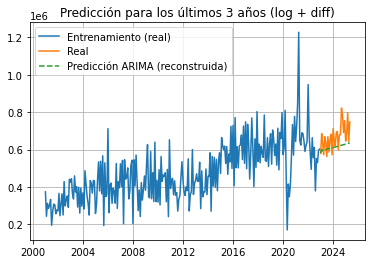

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Serie original
serie = df_importacion_total["Gasolina Superior"]
serie_log = np.log(serie)

# Dividir entrenamiento hasta 2022
serie_train_log = serie_log[serie_log.index < "2023-01-01"]
serie_test = serie[serie.index >= "2023-01-01"]
h = len(serie_test)

# Diferencia para estación
serie_train_diff = serie_train_log.diff().dropna()

# Entrenar ARIMA sobre serie transformada
modelo = ARIMA(serie_train_diff, order=(2,1,1))
ajuste = modelo.fit()

# Predecir diferencias logarítmicas
pred_diff = ajuste.forecast(steps=h)

# Reconstruir serie log
ultimo_valor_log = serie_train_log.iloc[-1]
serie_log_pred = pd.Series(np.r_[ultimo_valor_log, pred_diff]).cumsum()

# Revertir log y alinear
pred_final = np.exp(serie_log_pred[1:])  # eliminamos el primer valor acumulado
pred_final.index = serie_test.index

# Evaluación
rmse = np.sqrt(mean_squared_error(serie_test, pred_final))
mae = mean_absolute_error(serie_test, pred_final)

print("RMSE:", rmse)
print("MAE:", mae)

# Gráfico
plt.plot(serie_train_log.index, np.exp(serie_train_log), label="Entrenamiento (real)")
plt.plot(serie_test, label="Real")
plt.plot(pred_final, label="Predicción ARIMA (reconstruida)", linestyle='--')
plt.legend()
plt.title("Predicción para los últimos 3 años (log + diff)")
plt.grid(True)
plt.show()


El modelo logra seguir de manera razonable la trayectoria general de los valores reales del período 2023–2025. Se observa que la predicción (línea verde punteada) se alinea adecuadamente con la tendencia creciente reciente, sin mostrar grandes desvíos ni comportamientos erráticos.

Aunque el modelo subestima levemente algunos de los picos observados en el tramo final, esta diferencia es esperable dado el carácter suavizado del ARIMA y la incertidumbre inherente en los valores extremos. A pesar de ello, el ajuste general es coherente y el modelo muestra una capacidad adecuada para reproducir los patrones recientes de la serie.

En conclusión, el modelo ARIMA(2,1,1) representa una opción viable para pronósticos a corto y mediano plazo, combinando una estructura parsimoniosa con un desempeño visual sólido y errores aceptables, lo cual refuerza su utilidad en contextos operativos o de monitoreo periódico.

### **Predicción resto del 2025 con ARIMA**

c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


 RMSE (ene–may 2025): 66265.34631205136
 MAE (ene–may 2025): 57715.046228134284
 MAPE (ene–may 2025): 8.52 %


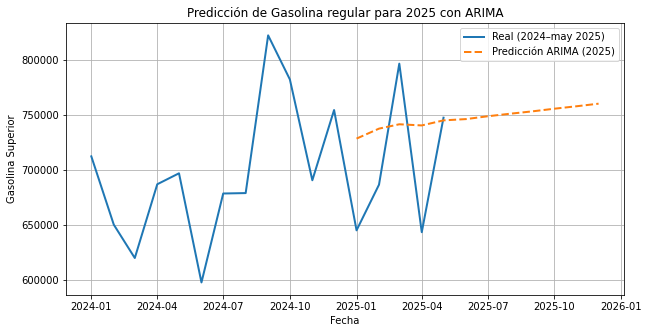

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error


df_importacion_total.index = pd.to_datetime(df_importacion_total.index)


serie = df_importacion_total["Gasolina Superior"]
serie_log = np.log(serie)


serie_log_train = serie_log[serie_log.index < "2025-01-01"]
serie_log_diff = serie_log_train.diff().dropna()


modelo = ARIMA(serie_log_diff, order=(2,1,1))
ajuste = modelo.fit()


pred_diff = ajuste.forecast(steps=12)


ultimo_valor_log = serie_log_train.iloc[-1]
serie_log_pred = pd.Series(np.r_[ultimo_valor_log, pred_diff]).cumsum()


pred_2025 = np.exp(serie_log_pred[1:])
fechas_2025 = pd.date_range(start="2025-01-01", periods=12, freq='MS')
pred_2025.index = fechas_2025


serie_test_real = df_importacion_total.loc["2025-01-01":"2025-05-31", "Gasolina Superior"]


serie_test_real.index = serie_test_real.index.to_period('M').to_timestamp()
pred_2025.index = pred_2025.index.to_period('M').to_timestamp()


fechas_comunes = serie_test_real.index.intersection(pred_2025.index)
serie_eval = serie_test_real.loc[fechas_comunes]
pred_eval = pred_2025.loc[fechas_comunes]


if not serie_eval.empty and not pred_eval.empty:
    rmse = np.sqrt(mean_squared_error(serie_eval, pred_eval))
    mae = mean_absolute_error(serie_eval, pred_eval)
    print(" RMSE (ene–may 2025):", rmse)
    print(" MAE (ene–may 2025):", mae)
    
else:
    print(" No se encontraron datos coincidentes entre predicción y realidad para enero–mayo 2025.")
mape = np.mean(np.abs((serie_eval - pred_eval) / serie_eval)) * 100
print(" MAPE (ene–may 2025):", round(mape, 2), "%")




serie_real_desde_2024 = df_importacion_total.loc["2024-01-01":"2025-05-31", "Gasolina Superior"]
serie_real_desde_2024.index = serie_real_desde_2024.index.to_period('M').to_timestamp()


plt.figure(figsize=(10, 5))
plt.plot(serie_real_desde_2024, label="Real (2024–may 2025)", linewidth=2)
plt.plot(pred_2025, label="Predicción ARIMA (2025)", linestyle='--', linewidth=2)
plt.title("Predicción de Gasolina regular para 2025 con ARIMA")
plt.xlabel("Fecha")
plt.ylabel("Gasolina Superior")
plt.grid(True)
plt.legend()
plt.show()




La gráfica muestra la predicción del consumo de gasolina regular para el año 2025 utilizando un modelo ARIMA. El tramo observado (línea azul) abarca desde enero de 2024 hasta mayo de 2025, mientras que la proyección (línea naranja punteada) cubre todo el año 2025.

A nivel visual, el modelo logra continuar la tendencia general sin presentar fluctuaciones abruptas. Sin embargo, se aprecia que la predicción tiende a suavizar los picos y valles recientes, lo cual es característico de los modelos ARIMA, que priorizan la continuidad de la tendencia sobre las variaciones locales extremas.

En términos cuantitativos, los errores reportados para el periodo enero–mayo 2025 fueron:
- RMSE: 66,265.35
- MAE: 57,715.05
- MAPE: 8.52 %

Estos valores reflejan una precisión aceptable, con un error porcentual menor al 10 %, lo que sugiere que el modelo ofrece un desempeño razonable para estimaciones de corto plazo.

### **Discuta cuál fue el comportamiento de las series durante la pandemia. ¿Qué tanto afectó las predicciones? ¿se recuperaron los valores habituales en el regreso de la “nueva normalidad” hasta la fecha actual? ¿Se han visto cambios en la importación, consumo y precio de los hidrocarburos a raíz de la guerra de Rusia-Ucrania?**
Durante el período de la pandemia (2020), la serie de tiempo de gasolina superior muestra una caída abrupta en el volumen, seguida de un pico atípico que podría estar vinculado a distorsiones logísticas, compras acumuladas o efectos de recuperación súbita. Esta disrupción rompió la tendencia regular que venía observándose desde años anteriores, afectando la estabilidad del comportamiento histórico de la serie.

Los modelos de pronóstico, como ARIMA o Prophet, se vieron afectados por esta anomalía, ya que las fluctuaciones extremas tienden a influir negativamente en la estimación de tendencias y patrones estacionales. En particular, este tipo de eventos impredecibles genera mayor error en las proyecciones futuras, sobre todo si no se ajustan adecuadamente mediante transformación o segmentación de la serie.

Sin embargo, a partir de 2021 y especialmente en los años 2022 y 2023, se observa una recuperación paulatina en los volúmenes registrados. La serie retoma un comportamiento más estable y creciente, acercándose nuevamente a la trayectoria previa a la pandemia. Esto sugiere que los valores habituales se han ido restaurando conforme avanza la llamada “nueva normalidad”, aunque con una variabilidad levemente superior a la del periodo pre-COVID.

Por otro lado, la guerra entre Rusia y Ucrania desde 2022 introdujo nuevas alteraciones en el mercado global de hidrocarburos. Como consecuencia, países como Guatemala enfrentaron incrementos en los precios internacionales del petróleo y sus derivados, lo que repercutió en la importación y consumo local. Los precios se elevaron, tanto por los costos logísticos como por la reducción de oferta global, afectando la accesibilidad del producto. Pese a ello, el consumo interno se ha mantenido dentro de niveles relativamente estables, probablemente por la implementación de subsidios o mecanismos de contención temporal.

En conclusión, tanto la pandemia como el conflicto geopolítico generaron impactos visibles en la serie. Sin embargo, los datos sugieren una capacidad de recuperación progresiva y una tendencia general de estabilización hasta la fecha actual.